## Data Preparation : Amazon Sales Report

In this project, i will demonstrate my skills in Data Preparation, using Python. This project involves a concise workflow: understanding the data, importing libraries, loading and merging datasets, addressing missing values and duplicates, converting data types, performing necessary transformations, exploring and visualizing the data, documenting the process, and ultimately saving the cleaned data.

The data used for this project is Amazon sales data, which includes various information such as SKU, Stock, Product Category, Size, Color, Price, Quantity Sold, etc. The

Source data: https://www.kaggle.com/datasets/thedevastator/unlock-profits-with-e-commerce-sales-data?select=Amazon+Sale+Report.csv

## Import Library

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)
import numpy as np
import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

## Support Function

In [2]:
def check_missing(df, cut_off=0, sort=True):
    freq=df.isnull().sum()
    percent=df.isnull().sum()/df.shape[0]*100
    types=df.dtypes
    unique = df.apply(pd.unique).to_frame(name='Unique Values')['Unique Values']
    df_miss=pd.DataFrame({'missing_percentage':percent, 'missing_frequency':freq, 'types':types, 'unique_values':unique})
    if sort: df_miss.sort_values(by='missing_frequency',ascending= False, inplace=True)
    return df_miss[df_miss['missing_percentage'] >= cut_off]

In [3]:
def fillna_by_metric(df, column_name, metric='mean', custom_value=None):
    # retrieve metric values based on input
    if metric == 'mean':
        metric_value = df[column_name].mean()
    elif metric == 'median':
        metric_value = df[column_name].median()
    elif metric == 'mode':
        metric_value = df[column_name].mode().iloc[0]
    elif metric == 'zero':
        metric_value = 0
    elif metric == 'custom':
        metric_value = custom_value
    else:
        raise ValueError("Invalid metric type")
    
    # fill missing values in the column with the retrieved metric values
    df[column_name].fillna(value=metric_value, inplace=True)
    
    return df

## Load Data

First, load the data from the CSV and preview the data. The data consists of two tables. The first table contains transaction data such as order ID, date, SKU, order details, and shipping details. The second table contains product information data such as SKU, stock, category, size, and color.

In [4]:
# load transaction data
df_transaction = pd.read_csv("Amazon Sale Report.csv")
df_transaction.head()

,index,Order ID,Date,Status,Fulfilment,Sales Channel,ship-service-level,Style,SKU,Category,Size,ASIN,Courier Status,Qty,currency,Amount,ship-city,ship-state,ship-postal-code,ship-country,promotion-ids,B2B,fulfilled-by,Unnamed: 22
0,0,405-8078784-5731545,04-30-22,Cancelled,Merchant,Amazon.in,Standard,SET389,SET389-KR-NP-S,Set,S,B09KXVBD7Z,NaN,0,INR,647.62,MUMBAI,MAHARASHTRA,400081.0,IN,NaN,False,Easy Ship,NaN
1,1,171-9198151-1101146,04-30-22,Shipped - Delivered to Buyer,Merchant,Amazon.in,Standard,JNE3781,JNE3781-KR-XXXL,kurta,3XL,B09K3WFS32,Shipped,1,INR,406.00,BENGALURU,KARNATAKA,560085.0,IN,Amazon PLCC Free-Financing Universal Merchant ...,False,Easy Ship,NaN
2,2,404-0687676-7273146,04-30-22,Shipped,Amazon,Amazon.in,Expedited,JNE3371,JNE3371-KR-XL,kurta,XL,B07WV4JV4D,Shipped,1,INR,329.00,NAVI MUMBAI,MAHARASHTRA,410210.0,IN,IN Core Free Shipping 2015/04/08 23-48-5-108,True,NaN,NaN
3,3,403-9615377-8133951,04-30-22,Cancelled,Merchant,Amazon.in,Standard,J0341,J0341-DR-L,Western Dress,L,B099NRCT7B,NaN,0,INR,753.33,PUDUCHERRY,PUDUCHERRY,605008.0,IN,NaN,False,Easy Ship,NaN
4,4,407-1069790-7240320,04-30-22,Shipped,Amazon,Amazon.in,Expedited,JNE3671,JNE3671-TU-XXXL,Top,3XL,B098714BZP,Shipped,1,INR,574.00,CHENNAI,TAMIL NADU,600073.0,IN,NaN,False,NaN,NaN


In [5]:
# load product info data
df_product_info = pd.read_csv("Sale Report.csv")
df_product_info.head()

,index,SKU Code,Design No.,Stock,Category,Size,Color
0,0,AN201-RED-L,AN201,5.0,AN : LEGGINGS,L,Red
1,1,AN201-RED-M,AN201,5.0,AN : LEGGINGS,M,Red
2,2,AN201-RED-S,AN201,3.0,AN : LEGGINGS,S,Red
3,3,AN201-RED-XL,AN201,6.0,AN : LEGGINGS,XL,Red
4,4,AN201-RED-XXL,AN201,3.0,AN : LEGGINGS,XXL,Red


## Join Data

To perform comprehensive statistical aggregation calculations, the two tables need to be merged using the SKU key present in both tables. Besides SKU, there are three other attributes (index, category, and size) present in both tables, so a choice needs to be made regarding which table's attributes to use.

For the 'index' attribute, it should suffice to use the one from the transaction data table. For the 'category' and 'size' attributes, use the data from the product info table, and if not found there, then use the data from the transaction table.

In [6]:
# drop and rename the necessary attributes in both tables
df_transaction['Category'] = df_transaction['Category'].str.upper()
df_transaction['Size'] = df_transaction['Size'].str.replace('3XL', 'XXXL')
df_transaction['Size'] = df_transaction['Size'].str.replace('Free', 'FREE')
df_transaction.rename(columns={'Category': 'Category1', 'Size': 'Size1'}, inplace=True)
df_product_info['Category'] = df_product_info['Category'].str.replace('AN : LEGGINGS', 'LEGGINGS')
df_product_info.rename(columns={'Category': 'Category2', 'Size': 'Size2', 'SKU Code': 'SKU'}, inplace=True)
df_product_info = df_product_info.drop(columns=['index'])

# join the tables
print(f'shape before: {df_transaction.shape}')
df = pd.merge(df_transaction, df_product_info, on='SKU', how='left')
print(f'shape after: {df.shape}')
df['Category'] = df.apply(lambda row: row['Category2'] if not pd.isna(row['Category2']) else row['Category1'], axis=1)
df['Size'] = df.apply(lambda row: row['Size2'] if not pd.isna(row['Size2']) else row['Size1'], axis=1)
df = df.drop(columns=['Category1','Category2','Size1','Size2',])

df.head()

shape before: (128975, 24)
shape after: (128975, 29)


,index,Order ID,Date,Status,Fulfilment,Sales Channel,ship-service-level,Style,SKU,ASIN,Courier Status,Qty,currency,Amount,ship-city,ship-state,ship-postal-code,ship-country,promotion-ids,B2B,fulfilled-by,Unnamed: 22,Design No.,Stock,Color,Category,Size
0,0,405-8078784-5731545,04-30-22,Cancelled,Merchant,Amazon.in,Standard,SET389,SET389-KR-NP-S,B09KXVBD7Z,NaN,0,INR,647.62,MUMBAI,MAHARASHTRA,400081.0,IN,NaN,False,Easy Ship,NaN,SET389,32.0,White,SET,S
1,1,171-9198151-1101146,04-30-22,Shipped - Delivered to Buyer,Merchant,Amazon.in,Standard,JNE3781,JNE3781-KR-XXXL,B09K3WFS32,Shipped,1,INR,406.00,BENGALURU,KARNATAKA,560085.0,IN,Amazon PLCC Free-Financing Universal Merchant ...,False,Easy Ship,NaN,JNE3781,96.0,Green,KURTA,XXXL
2,2,404-0687676-7273146,04-30-22,Shipped,Amazon,Amazon.in,Expedited,JNE3371,JNE3371-KR-XL,B07WV4JV4D,Shipped,1,INR,329.00,NAVI MUMBAI,MAHARASHTRA,410210.0,IN,IN Core Free Shipping 2015/04/08 23-48-5-108,True,NaN,NaN,JNE3371,4.0,Light Green,KURTA,XL
3,3,403-9615377-8133951,04-30-22,Cancelled,Merchant,Amazon.in,Standard,J0341,J0341-DR-L,B099NRCT7B,NaN,0,INR,753.33,PUDUCHERRY,PUDUCHERRY,605008.0,IN,NaN,False,Easy Ship,NaN,J0341,193.0,Blue,DRESS,L
4,4,407-1069790-7240320,04-30-22,Shipped,Amazon,Amazon.in,Expedited,JNE3671,JNE3671-TU-XXXL,B098714BZP,Shipped,1,INR,574.00,CHENNAI,TAMIL NADU,600073.0,IN,NaN,False,NaN,NaN,JNE3671,6.0,Pink,TUNIC,XXXL


The left join process is successful because the number of rows did not increase, meaning there are no duplicate data after the left join.

## Handle Missing Value and Duplicate

After successfully joining the data, it is necessary to inspect the data to identify which attributes have missing values and how many missing values they have. This step helps determine how to address the missing values, whether by using the mean, median, mode, 0, or other custom values.

In [7]:
check_missing(df)

,missing_percentage,missing_frequency,types,unique_values
fulfilled-by,69.546811,89698,object,"[Easy Ship, nan]"
promotion-ids,38.110487,49153,object,"[nan, Amazon PLCC Free-Financing Universal Mer..."
Unnamed: 22,38.030626,49050,object,"[nan, False]"
Amount,6.043807,7795,float64,"[647.62, 406.0, 329.0, 753.33, 574.0, 824.0, 6..."
currency,6.043807,7795,object,"[INR, nan]"
Color,5.974801,7706,object,"[White, Green, Light Green, Blue, Pink, Gold, ..."
Stock,5.974801,7706,float64,"[32.0, 96.0, 4.0, 193.0, 6.0, 81.0, 1.0, 423.0..."
Design No.,5.974801,7706,object,"[SET389, JNE3781, JNE3371, J0341, JNE3671, SET..."
Courier Status,5.328164,6872,object,"[nan, Shipped, Cancelled, Unshipped]"
ship-state,0.025586,33,object,"[MAHARASHTRA, KARNATAKA, PUDUCHERRY, TAMIL NAD..."


Based on the inspection results, the following steps have been decided to manipulate the data:
1. The 'fulfilled-by' and 'Unnamed: 22' columns are not needed and have a high missing percentage, so will be removed from the table.
2. The 'currency' and 'ship-country' columns have only 1 unique value with a low missing percentage, so will be removed from the table. It is assumed that all data belongs to the ship-country India and is in the currency Indian Rupee.
3. The "courier status" column, which has been represented by the "status" column, will be deleted.
4. The "date" column will be converted to a datetime format.
5. The "postal code" column will be converted to an object data type.
6. Missing values in the numeric 'Amount' column will be filled using the mean.
7. Missing values in the numeric 'Stock' column will be filled with 0.
8. Missing values in string columns will be filled with 'Others'.

In [8]:
# delete unnecessary columns
df = df.drop(columns=['fulfilled-by','Unnamed: 22','currency','ship-country','Courier Status'])

# data type conversion
df['Date'] = pd.to_datetime(df['Date'], format='%m-%d-%y')
df['ship-postal-code'] = df['ship-postal-code'].apply(lambda x: str(int(x)) if not pd.isna(x) else x)

# handle missing value
for col in ['Amount']:
    df = fillna_by_metric(df, column_name=col, metric='mean') 
for col in ['Stock']:
    df = fillna_by_metric(df, column_name=col, metric='zero')
for col in ['Color','Design No.', 'promotion-ids','ship-state','ship-city','ship-postal-code']:
    df = fillna_by_metric(df, column_name=col, metric='custom', custom_value='Others')

# remove duplicate
df = df.drop_duplicates()

# rename columns name
df.rename(columns={'ship-service-level': 'Ship Service Level', 'ship-city': 'Ship City','ship-state': 'Ship State',
                   'ship-postal-code': 'Ship Postal Code', 'promotion-ids': 'Promotion IDs',
                   'Sales Channel ': 'Sales Channel'}, inplace=True)

df.head()

,index,Order ID,Date,Status,Fulfilment,Sales Channel,Ship Service Level,Style,SKU,ASIN,Qty,Amount,Ship City,Ship State,Ship Postal Code,Promotion IDs,B2B,Design No.,Stock,Color,Category,Size
0,0,405-8078784-5731545,2022-04-30,Cancelled,Merchant,Amazon.in,Standard,SET389,SET389-KR-NP-S,B09KXVBD7Z,0,647.62,MUMBAI,MAHARASHTRA,400081,Others,False,SET389,32.0,White,SET,S
1,1,171-9198151-1101146,2022-04-30,Shipped - Delivered to Buyer,Merchant,Amazon.in,Standard,JNE3781,JNE3781-KR-XXXL,B09K3WFS32,1,406.00,BENGALURU,KARNATAKA,560085,Amazon PLCC Free-Financing Universal Merchant ...,False,JNE3781,96.0,Green,KURTA,XXXL
2,2,404-0687676-7273146,2022-04-30,Shipped,Amazon,Amazon.in,Expedited,JNE3371,JNE3371-KR-XL,B07WV4JV4D,1,329.00,NAVI MUMBAI,MAHARASHTRA,410210,IN Core Free Shipping 2015/04/08 23-48-5-108,True,JNE3371,4.0,Light Green,KURTA,XL
3,3,403-9615377-8133951,2022-04-30,Cancelled,Merchant,Amazon.in,Standard,J0341,J0341-DR-L,B099NRCT7B,0,753.33,PUDUCHERRY,PUDUCHERRY,605008,Others,False,J0341,193.0,Blue,DRESS,L
4,4,407-1069790-7240320,2022-04-30,Shipped,Amazon,Amazon.in,Expedited,JNE3671,JNE3671-TU-XXXL,B098714BZP,1,574.00,CHENNAI,TAMIL NADU,600073,Others,False,JNE3671,6.0,Pink,TUNIC,XXXL


In [9]:
check_missing(df, cut_off=0.00001)

,missing_percentage,missing_frequency,types,unique_values


In [10]:
df[df.duplicated()]

,index,Order ID,Date,Status,Fulfilment,Sales Channel,Ship Service Level,Style,SKU,ASIN,Qty,Amount,Ship City,Ship State,Ship Postal Code,Promotion IDs,B2B,Design No.,Stock,Color,Category,Size


Handling missing value and duplicate is complete, the data format is now as required, missing values have been filled with appropriate values, and there are no duplicates.

## Data Exploration and Visualization

In the data exploration and visualization, the aim is to gain a deeper understanding of the data, identify patterns or trends that may exist, and assess whether the data meets the assumptions required for the analysis.

In [11]:
df.describe()

,index,Qty,Amount,Stock
count,128975.000000,128975.000000,128975.000000,128975.000000
mean,64487.000000,0.904431,648.561465,64.422772
std,37232.019822,0.313354,272.581240,140.323023
min,0.000000,0.000000,0.000000,0.000000
25%,32243.500000,1.000000,459.000000,4.000000
50%,64487.000000,1.000000,635.000000,12.000000
75%,96730.500000,1.000000,771.000000,59.000000
max,128974.000000,15.000000,5584.000000,1234.000000


Text(0.5, 1.0, 'Quantity Boxplot')

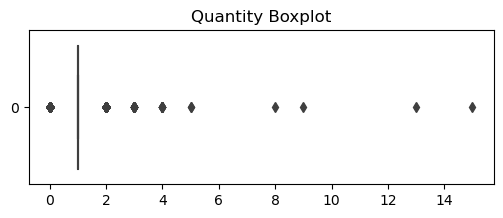

In [12]:
# boxplot for 'Qty' column
plt.figure(figsize=(6, 2))
sns.boxplot(df['Qty'], orient='h')
plt.title("Quantity Boxplot")

Text(0.5, 1.0, 'Amount Boxplot')

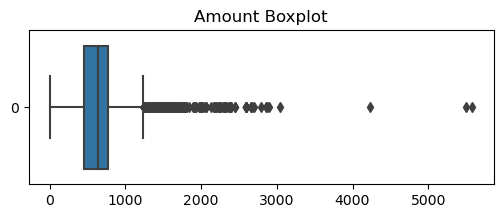

In [13]:
# boxplot for 'Amount' column
plt.figure(figsize=(6, 2))
sns.boxplot(df['Amount'], orient='h')
plt.title("Amount Boxplot")

Text(0.5, 1.0, 'Stock Boxplot')

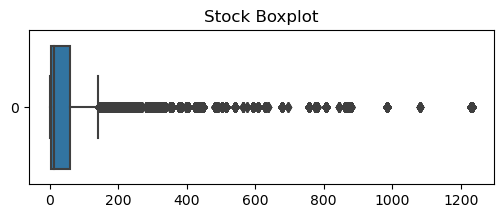

In [14]:
# boxplot for 'Stock' column
plt.figure(figsize=(6, 2))
sns.boxplot(df['Stock'], orient='h')
plt.title("Stock Boxplot")

Based on the inspection results, the following steps have been decided to manipulate the data:
1. Rows with value 0.0 in 'Amount' are considered data input errors, so will be removed from the table.
2. Value 0 in 'Qty' are considered data input errors, so will be replaced with mode.

In [15]:
# remove and replace error data inputs
df = df[df['Amount'] != 0.0]
mode_qty = df['Qty'].mode().values[0]
df['Qty'] = df['Qty'].replace(0, mode_qty)

df.describe()

,index,Qty,Amount,Stock
count,126632.000000,126632.000000,126632.000000,126632.000000
mean,64458.500340,1.003798,660.561429,64.324397
std,37222.288647,0.090327,260.285435,140.348996
min,0.000000,1.000000,199.000000,0.000000
25%,32218.750000,1.000000,467.000000,4.000000
50%,64426.500000,1.000000,635.000000,12.000000
75%,96687.250000,1.000000,772.095000,59.000000
max,128974.000000,15.000000,5584.000000,1234.000000


## Export Data

The data are exported to CSV format, making it suitable for further analysis.

In [16]:
df.to_csv('Amazon Sale Report Clean.csv', index=False)